<a href="https://colab.research.google.com/github/xc308/Diffusion_Sampling/blob/main/Diffusion_vs_Optimal_Transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Aim: compare two transport methods to transport a mixture of Gaussians (or Dirac masses) to an isotropic Gaussian:

  - __Diffusion models__ integrate the score (log-density gradient), resulting in smooth, curved trajectories.
  - __Optimal transport (OT)__ moves particles along straight lines that minimize transport cost.

Then visualize and compare the resulting mappings to highlight their different behaviors.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### define a mixture of Gaussians in 2D by specifying:

  - mu: the coordinates of the Gaussian means (shape 2 by K),
  - K: the number of components,
  - sigma: the standard deviation (initialized here to zero for each component),
  - a: uniform weights for each component (summing to 1).

In [3]:
mu = torch.randn(2,5)*8    # 2 rows and 5 cols, each mu is two-d with mu_x, mu_y,
                           # 5 random 2D vectors (5 points in 2D)
                           # each coords of mu is from N(0, 1)
                           # mulitpy by 8 scales the std from 1 to 8
                           # so each coords ~ N(0, 8**2)

K = mu.shape[1]
print(K)
sigma = torch.zeros(K)
a = torch.ones(K)/K # weight, should sum to 1

5


## Time-dependent density  𝜌(𝑥,𝑡)

- a mixture of Gaussian with:
    - mean mu_i(t)= mu_i * exp(-t)
    - Time-evolving variances:
        - sig_i(t)^2 = exp(-2t) * sig_i^2 + (1 - exp(-2t))
    
   

- the score of the 𝜌(𝑥,𝑡) is 𝜂(𝑥,𝑡)=∇𝑥log𝜌(𝑥,𝑡)


-

In [4]:
def gauss(x,m,s):
  return 1/( 2*torch.tensor(torch.pi) * s**2 ) * torch.exp( -( (x-m[:,None])**2 ).sum(axis=0) / (2*s**2) )


def gaus_mixture(x,mu,sigma,a):
    y = torch.zeros(x.shape[1])
    for i in range(len(a)):
        y = y + a[i] * gauss(x,mu[:,i],sigma[i])
    return y


def rho(x,t):
    sigma_t = torch.sqrt( torch.exp(-2*t)*sigma**2 + 1-torch.exp(-2*t) )
    return gaus_mixture(x, mu*torch.exp(-t), sigma_t,a)


def eta(x,t):
    x1 = x.detach().clone() # detach() breaks any connection that generate x for clean backpropagation
                            # clone() makes a new tensor with its own storage
    x1.requires_grad = True  # makes x1 a leaf variable that PyTorch will store gradients for in x1.grad
    L = torch.sum( rho(x1,t) ) # scalar
    L.backward()
    return x1.grad / rho(x,t)[None,:]


## Simulate a backward diffusion process

defined by the stochastic differential equation:
    𝑑𝑌𝑡 = 𝑌𝑡 + (1+𝛼) 𝜂𝑡(𝑌𝑡) 𝑑𝑡 +2√𝑑𝑊𝑡,

 - Where 𝜂𝑡(𝑌𝑡) is the score (gradient of log-density), and  𝑊𝑡  is standard Brownian motion.

 - By setting  𝛼=0 , the evolution becomes deterministic, reducing to:

      𝑑𝑌𝑡 = 𝑌𝑡 + 𝜂𝑡(𝑌𝑡) 𝑑𝑡


In [8]:
# set alpha=0 to obtain deterministic paths
alpha = .03
#alpha = 0 # pure advection


T = 20 # final time
N = 2500 # number of steps
tau = T / N # step size
P = 200 # particules


Y = torch.zeros((2,P,N))
Y[:,:,0] = torch.randn((2,P)) # initial positions (Gaussian)
t = torch.tensor(T)
for i in range(N-1):
    Y[:,:,i+1] = Y[:,:,i]  + tau * ( Y[:,:,i] + (1+alpha)*eta(Y[:,:,i],t) ) + torch.sqrt(2 * torch.tensor(tau * alpha)) * torch.randn((2,P))
    t = t-tau


#Y[:, j, i] is the 2D position (x,y) of particle j at time step i



## Visualisation the particle trajectories over time
- simulating the transport from the isotropic Gaussian to the initial distribution

- each final point is assigned to the nearest initial Dirac center (from mu)

-  its full trajectory is colored

    - Trajectories are shown with semi-transparent lines
    - Starting points are marked with colored dots
    - Dirac centers (mu) are displayed as large black dots




the Gaussian mass is partitioned and directed toward different components of the original mixture.

## Compute the nearest mu cluster for each trajectory

In [9]:
final_points = Y[:, :, -1]  # Shape: (2, P) all the points of all trajactories at the final time step
distances = torch.cdist(final_points.T, mu.T)  # Shape: (P, K)
cluster_indices = torch.argmin(distances, axis=1)  # Shape: (P,)


## Display trajectories clustered by color with semi-transparency and final dots

/tmp/ipython-input-38252264.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", mu.shape[1])  # Use a colormap with K colors


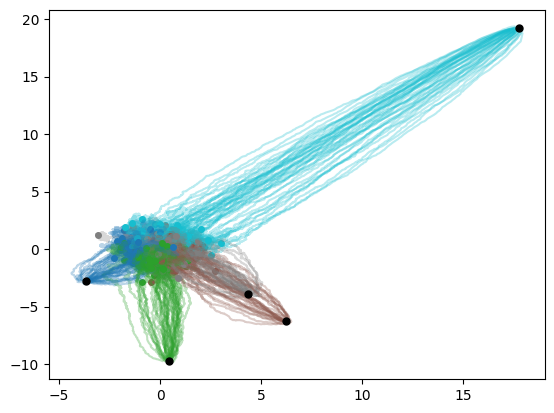

In [10]:
colors = plt.cm.get_cmap("tab10", mu.shape[1])  # Use a colormap with K colors
for k in range(P):
    cluster_color = colors(cluster_indices[k].item())
    plt.plot(Y[0, k, :].numpy(), Y[1, k, :].numpy(), '-', color=cluster_color, alpha=0.3)  # Semi-transparent line
    plt.plot(Y[0, k, 0].numpy(), Y[1, k, 0].numpy(), 'o', color=cluster_color, markersize=4)  # Final point dot


plt.plot(mu[0, :].numpy(), mu[1, :].numpy(), 'k.', markersize=10)  # Plot the mu points
plt.show()

## optimal transport plan

- using the POT library by solving the Kantorovich problem between:
    - Source points xi (initial Gaussian samples),
    - Target points mu (Dirac locations),
    - With uniform weights for both distributions

- The cost matrix is the squared Euclidean distance

- visualize the resulting transport plan by drawing segments between matched source and target points

    - Color indicating the target Dirac each source point is mostly mapped to
    - Transparency reflecting transport strength
    - Target locations (mu) shown as black dot

-

In [13]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.2 MB/s eta 0:00:00


/tmp/ipython-input-952895374.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cost_matrix = torch.tensor(ot.dist(xi, yj, metric='euclidean')**2)


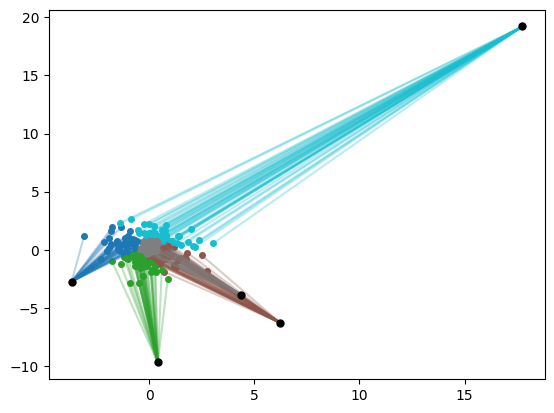

In [14]:
import ot
xi = Y[:,:,0].T
yj = mu.T
n = xi.shape[0]
m = yj.shape[0]

cost_matrix = torch.tensor(ot.dist(xi, yj, metric='euclidean')**2)
a = torch.ones(n) / n  # Source weights
b = torch.ones(m) / m  # Target weights
P = ot.emd(a, b, cost_matrix)  # Solves the Kantorovich problem

# Draw transport segments based on P_ij
for i in range(n):
    for j in range(m):
        if P[i, j] > 1e-3:  # Only draw segments with significant transport
            plt.plot([xi[i, 0], yj[j, 0]], [xi[i, 1], yj[j, 1]], color=colors(j), alpha=0.3)
            plt.plot(xi[i, 0], xi[i, 1], 'o', color=colors(j), markersize=4)  # Final point dot
plt.plot(mu[0, :].numpy(), mu[1, :].numpy(), 'k.', markersize=10)  # Plot the mu points